# Second Script

#### This is the result from the first script where we compute log-ratio of fractions of frequencies for each pair of residues per a given distance in the table.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
ls ../outputs/pseudo_energies

pseudo_energy_1E95.csv    pseudo_energy_7wii.csv    pseudo_energy_CUG.csv
pseudo_energy_7FHI.csv    pseudo_energy_8CLR.csv    pseudo_energy_NAD-II.csv
pseudo_energy_7sxp.csv    pseudo_energy_8UTP.csv    pseudo_energy_U3.csv


In [3]:
energies = pd.read_csv('../outputs/pseudo_energies/pseudo_energy_7FHI.csv', index_col=0)
indexes = energies.index.tolist()

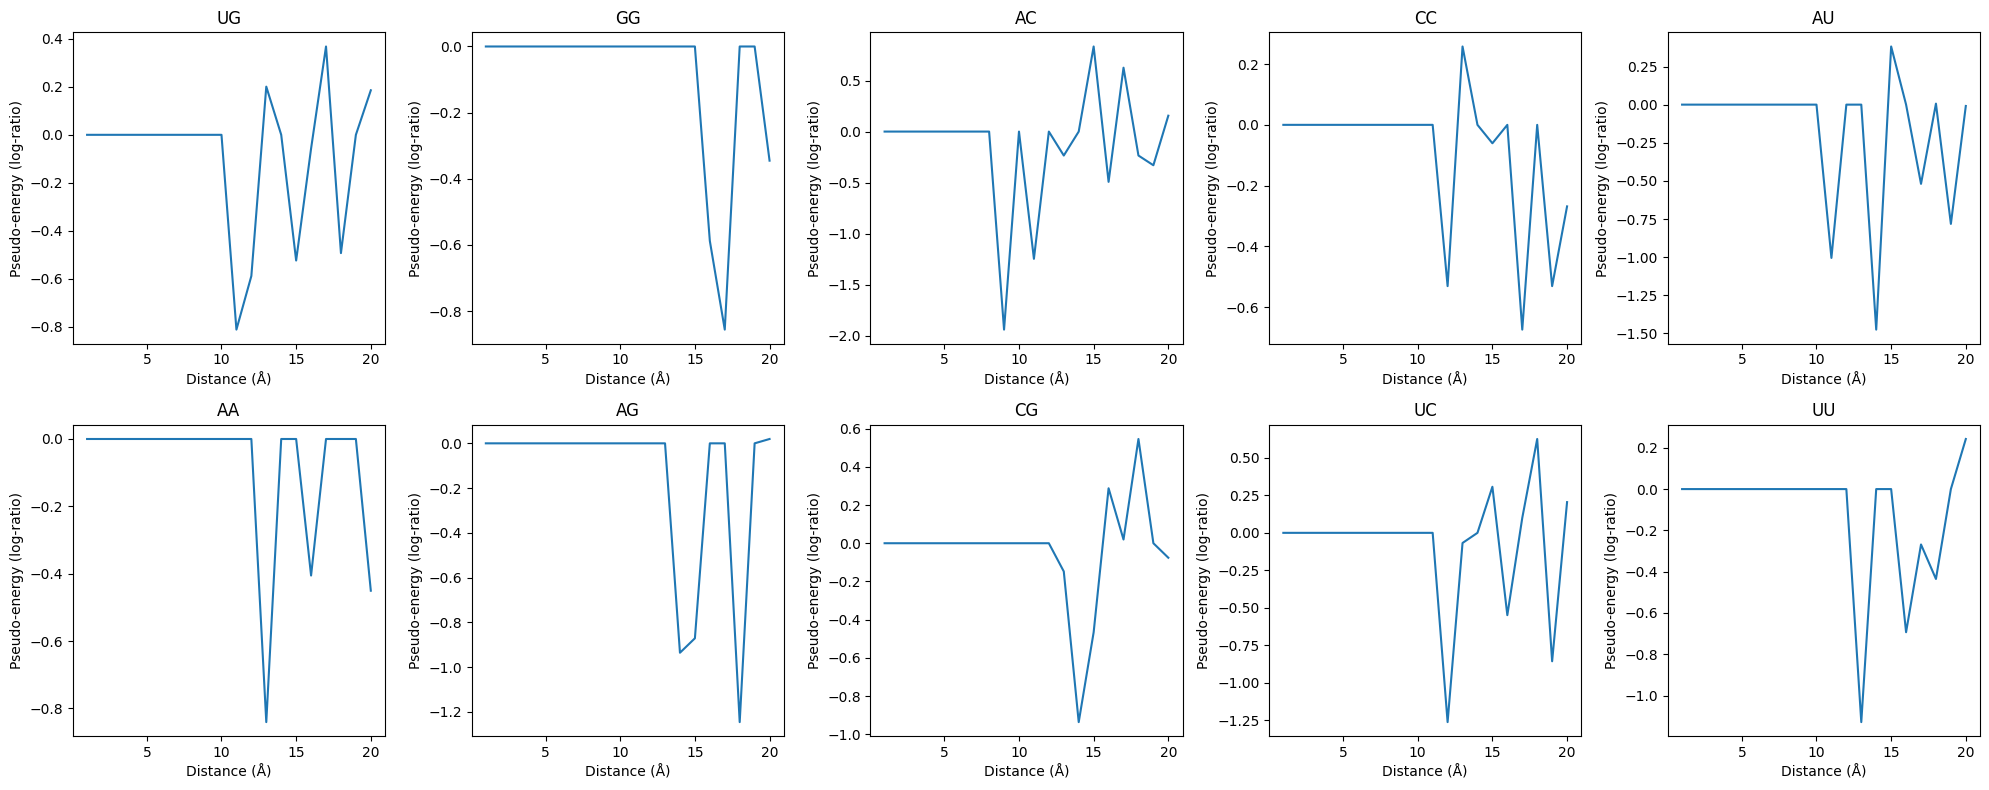

In [4]:
fig, ax = plt.subplots(2, 5, figsize=(20, 8), squeeze=False)
ax = ax.flatten()

for q in range(energies.shape[0]):
    ax[q].plot(np.arange(1, 21), energies.iloc[q, :])
    ax[q].set_ylabel("Pseudo-energy (log-ratio)")
    ax[q].set_xlabel("Distance (Å)")
    ax[q].set_title(indexes[q])

plt.tight_layout()
plt.show()

# Third Script

In [5]:
import numpy as np

#### Because we have multiple log-ratios for the same distance the only thing we could do to compute linear interpolation for any given distance - is to compute average of all log ratios for a given distance. Then sum up all these averaged scores from all distances to get a Gibbs free energy. This is what we did.

In [6]:
import numpy as np

def linear_interpolation(x_values, y_values):
    """
    Performs linear interpolation for a set of points.

    Parameters:
    - x_values: List or numpy array of x values
    - y_values: List or numpy array of corresponding y values

    Returns:
    - Function that takes an x value or array and outputs the interpolated y value or array
    """
    x_values, y_values = np.asarray(x_values), np.asarray(y_values)

    def interpolate(x):
        # Find the indices of the closest x values in the given data
        indices = np.searchsorted(x_values, x, side='right')

        # Handle cases where x is beyond the range of provided data
        indices = np.clip(indices, 1, len(x_values) - 1)

        # Linear interpolation formula using numpy array operations
        x0, x1 = x_values[indices - 1], x_values[indices]
        y0, y1 = y_values[indices - 1], y_values[indices]
        return y0 + (y1 - y0) * (x - x0) / (x1 - x0)

    return np.vectorize(interpolate)

Let's see the results of our linear interpolation function on a 100 points on a [1, 20] grid:

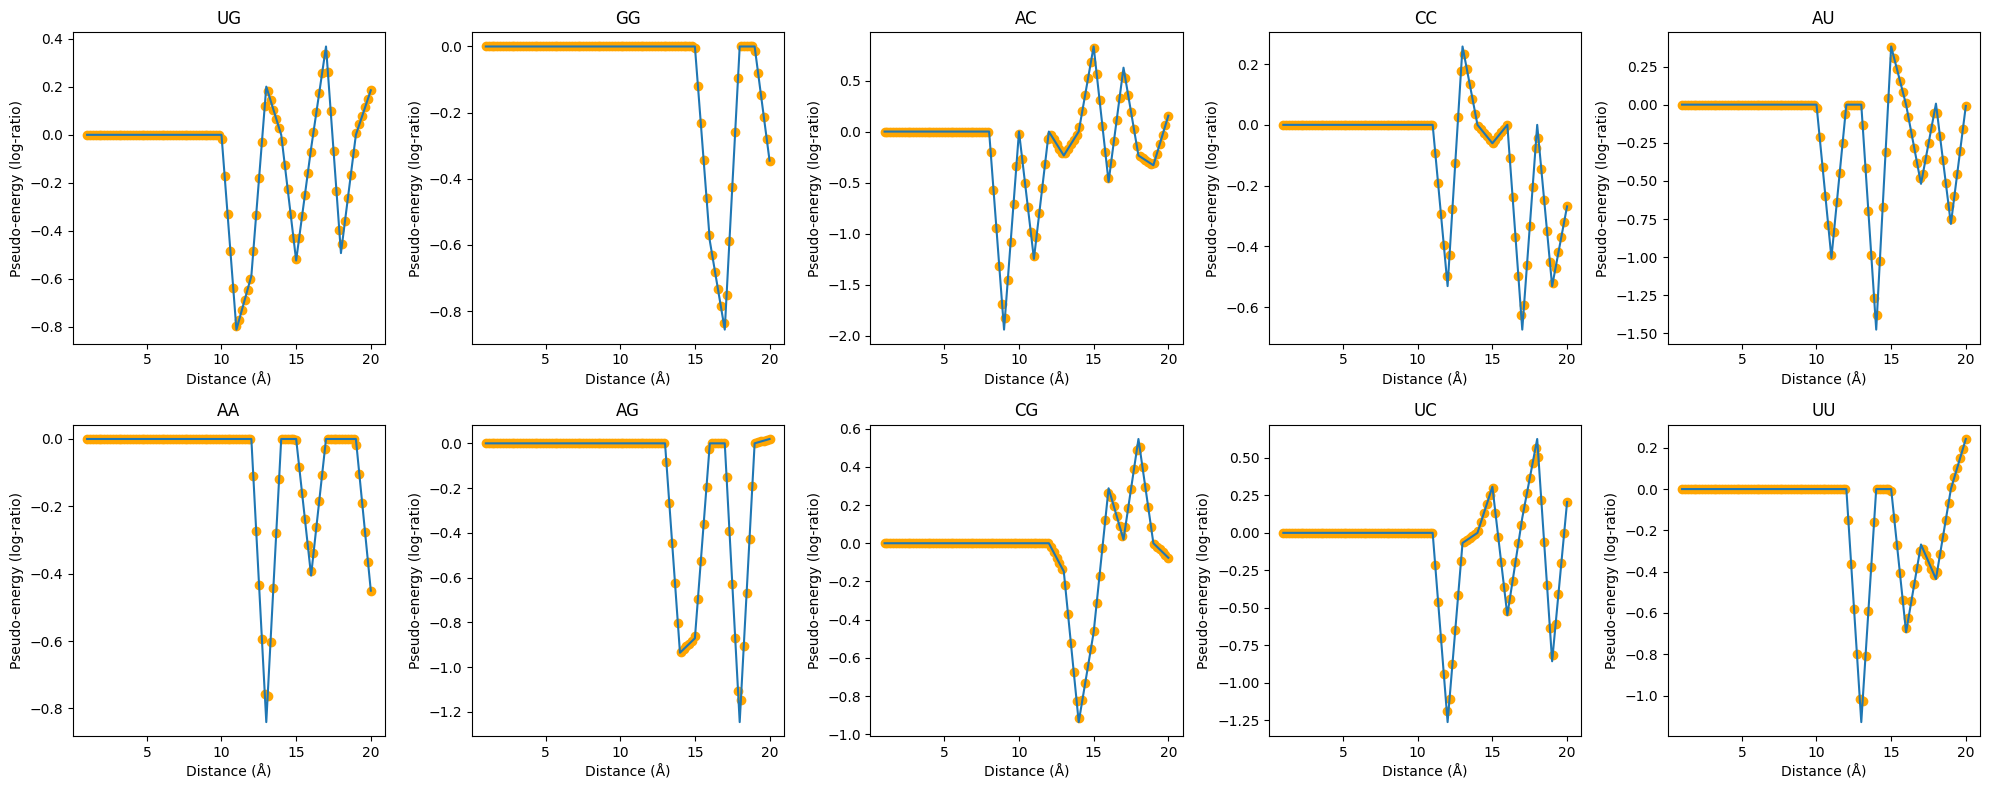

In [7]:
fig, ax = plt.subplots(2, 5, figsize=(20, 8), squeeze=False)
ax = ax.flatten()

for q in range(energies.shape[0]):
    ax[q].plot(np.arange(1, 21), energies.iloc[q, :])

    interpol = linear_interpolation(x_values=energies.iloc[q].index.astype('float').values, y_values=energies.iloc[q].values)
    interpols = interpol(np.linspace(1, 20, 100))
    ax[q].scatter(x=np.linspace(1, 20, 100), y=interpols, color='orange')

    ax[q].set_ylabel("Pseudo-energy (log-ratio)")
    ax[q].set_xlabel("Distance (Å)")
    ax[q].set_title(indexes[q])

plt.tight_layout()
plt.show()

> the interpolation works as intended

Converting .txt files to .json for more convenient storage and easier accession:

In [8]:
import json

def convert_txt_to_json(txt_file_path, json_file_path):
    data = {}

    with open(txt_file_path, 'r') as file:
        current_key = None
        for line in file:
            line = line.strip()
            if line and not line.endswith(':'):
                parts = line.split()
                current_key = parts[0]
                try:
                    values = [float(val) for val in parts[1:]]
                    data[current_key[:-1]] = values
                except ValueError as e:
                    raise ValueError(f"Error processing line: {line}. {e}")

    with open(json_file_path, 'w') as json_file:
        json.dump(data, json_file, indent=2)

In [9]:
dists = ! ls ../outputs/distances

for dist in dists:
    dist_filename = dist.split('.')[0]
    txt_file_path = f"../outputs/distances/{dist_filename}.txt"
    json_file_path = f"../outputs/distances/{dist_filename}.json"
    convert_txt_to_json(txt_file_path, json_file_path)

In [10]:
def energy_calculation(coord_dict, energies):
    """
    Performs energy calculation using the interpolation for a set of energy points.

    Parameters:
    - coord_dict: Dict of calculated distances for each nucleotide pairs loaded from a json
    - energies: DataFrame of calculated pseudo energies

    Returns:
    - the calculated value of Gibbs free energy
    """
    scores = np.array([])
    
    for nt_pair in coord_dict.keys():
        pair_energy = energies.loc[nt_pair]
        interpol = linear_interpolation(x_values=pair_energy.index.astype('float').values, 
                                        y_values=pair_energy.values)
        scores = interpol(coord_dict[nt_pair])
        scores = np.append(scores, np.sum(pair_energy) / energies.shape[1])

        
    gibbs_free_energy = np.sum(scores)
    return(gibbs_free_energy)

Example: Calculating the Gibbs free energy for `7FHI`:

In [11]:
def end2end_gibbs(rna_name):
    energies = pd.read_csv(f'../outputs/pseudo_energies/pseudo_energy_{rna_name}.csv', index_col=0)
    
    json_file_path = f"../outputs/distances/{rna_name}.json"
    with open(json_file_path, 'r') as json_file:
        dists = json.load(json_file)

    gibbs_free_energy = energy_calculation(dists, energies)

    print(f'The calculated Gibbs free energy for {rna_name} is:\t{gibbs_free_energy}')
    return gibbs_free_energy

In [12]:
rna_name = '7FHI'

end2end_gibbs(rna_name);

The calculated Gibbs free energy for 7FHI is:	-0.7636618565600007


> As you may see, the Gibbs fre energy in our case is lower than zero. So the system might not be in equilibrium and changes may occur spontaneously.

Calculating the Gibbs free energy for every pdb from our `/data`:

In [13]:
import re

def extract_rna_name(energy_filename):
    pattern = r'_([^_]+)\.csv'
    match = re.search(pattern, energy_filename)
    if match:
        rna_value = match.group(1)
        return rna_value
    else:
        print("No match found.")

energy_filenames = ! ls ../outputs/pseudo_energies
pattern = r'_(\d+E\d+)\.csv'
rna_names = [extract_rna_name(item) for item in energy_filenames]

In [14]:
rna_names

['1E95', '7FHI', '7sxp', '7wii', '8CLR', '8UTP', 'CUG', 'NAD-II', 'U3']

In [15]:
for rna_name in rna_names:
    end2end_gibbs(rna_name);

The calculated Gibbs free energy for 1E95 is:	-1.7374601497399988
The calculated Gibbs free energy for 7FHI is:	-0.7636618565600007
The calculated Gibbs free energy for 7sxp is:	-1.0125107499839976
The calculated Gibbs free energy for 7wii is:	-49.565014182354005
The calculated Gibbs free energy for 8CLR is:	-1.423030051650001
The calculated Gibbs free energy for 8UTP is:	-233.12768942847404
The calculated Gibbs free energy for CUG is:	5.5896461923829985
The calculated Gibbs free energy for NAD-II is:	43.307083211968994
The calculated Gibbs free energy for U3 is:	-2.0157701964919994
